In [ ]:
!pip install sentence-transformers
!pip install torch torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch_geometric.nn import GAE, GCN2Conv
import torch.nn.functional as F
from torch.nn import Linear
import os
import torch

num_features = 392
print(num_features)
hidden = 128
out_channels = 32

class GCNEncoder(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, num_layers, alpha, theta, shared_weights=True, dropout=0.0):
        super().__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(Linear(input_channels, hidden_channels))
        self.lins.append(Linear(hidden_channels, output_channels))

        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(
                GCN2Conv(hidden_channels, alpha, theta, layer + 1,
                         shared_weights, normalize=False))

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, self.dropout, training=self.training)
        x = x_0 = self.lins[0](x).relu()

        for conv in self.convs:
            x = F.dropout(x, self.dropout, training=self.training)
            x = conv(x, x_0, edge_index)
            x = x.relu()

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lins[1](x)

        return x

encoder = GCNEncoder(input_channels=num_features, hidden_channels=hidden, output_channels=out_channels, num_layers=6, alpha=0.1, theta=0.5, shared_weights=True, dropout=0.1)
model = GAE(encoder)
EPOCH = 21

MODEL_PATH = f"/content/drive/MyDrive/product_page_dataset/model/product_page_model_4_{EPOCH}.torch"

if os.path.exists(MODEL_PATH):
  print("loading model from", MODEL_PATH)
  model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

print(model)

392
loading model from /content/drive/MyDrive/product_page_dataset/model/product_page_model_4_21.torch


<ipython-input-3-34a9939c9be3>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))


GAE(
  (encoder): GCNEncoder(
    (lins): ModuleList(
      (0): Linear(in_features=392, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=32, bias=True)
    )
    (convs): ModuleList(
      (0): GCN2Conv(128, alpha=0.1, beta=0.4054651081081644)
      (1): GCN2Conv(128, alpha=0.1, beta=0.22314355131420976)
      (2): GCN2Conv(128, alpha=0.1, beta=0.15415067982725836)
      (3): GCN2Conv(128, alpha=0.1, beta=0.11778303565638346)
      (4): GCN2Conv(128, alpha=0.1, beta=0.09531017980432493)
      (5): GCN2Conv(128, alpha=0.1, beta=0.08004270767353636)
    )
  )
  (decoder): InnerProductDecoder()
)


In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(model))

152736


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import pickle
import os

# List of unique HTML tags
html_tags = [
    'a', 'abbr', 'address', 'area', 'article', 'aside', 'audio', 'b', 'base', 'bdi', 'bdo', 'blockquote',
    'body', 'br', 'button', 'canvas', 'caption', 'cite', 'code', 'col', 'colgroup', 'data', 'datalist', 'dd',
    'del', 'details', 'dfn', 'dialog', 'div', 'dl', 'dt', 'em', 'embed', 'fieldset', 'figcaption', 'figure',
    'footer', 'form', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'head', 'header', 'hr', 'html', 'i', 'iframe', 'img',
    'input', 'ins', 'kbd', 'label', 'legend', 'li', 'link', 'main', 'map', 'mark', 'meta', 'meter', 'nav', 'noscript',
    'object', 'ol', 'optgroup', 'option', 'output', 'p', 'param', 'picture', 'pre', 'progress', 'q', 'rp', 'rt', 'ruby',
    's', 'samp', 'script', 'section', 'select', 'small', 'source', 'span', 'strong', 'style', 'sub', 'summary', 'sup',
    'table', 'tbody', 'td', 'template', 'textarea', 'tfoot', 'th', 'thead', 'time', 'title', 'tr', 'track', 'u', 'ul',
    'var', 'video', 'wbr'
]


TAG_PATH = f'/content/drive/MyDrive/product_page_dataset/tag_embeddings.pkl'

class TagEmbeddingModel:
    def __init__(self):
      if os.path.exists(TAG_PATH):
        with open(TAG_PATH, 'rb') as f:
          print("Loading tag embeddings from file")
          self.embedding_vectors = pickle.load(f)
      else:
        # Initialize and fit Tokenizer
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(html_tags)
        sequences = tokenizer.texts_to_sequences(html_tags)

        # Pad sequences to ensure uniform length
        tag_sequences = pad_sequences(sequences)

        # Define the size of the embedding
        embedding_dim = 8  # Example dimension size

        # Create a simple embedding model
        model = Sequential([
            Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=1)
        ])

        # Get the embedding vectors
        self.embedding_vectors = model.predict(tag_sequences)

    def get_tag_embedding(self, tags):
        return [self.embedding_vectors[html_tags.index(tag)][0] for tag in tags]


In [ ]:
from sentence_transformers import SentenceTransformer
import nltk
from nltk.tokenize import sent_tokenize
from functools import lru_cache

TEXT_EMBEDDING = 384

class TextEmbeddingModel:
    def __init__(self):
        nltk.download('punkt')
        self.model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')

    def get_text_embeddings(self, text):
        sentences = []
        for t in text:
            sentence = sent_tokenize(t)
            if sentence:
                sentences.append(sentence[0])
            else:
                sentences.append("")
        return self.model.encode(sentences)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
from lxml import etree
import torch


class Web:
    def __init__(self):
        self.tag_model = TagEmbeddingModel()
        self.text_model = TextEmbeddingModel()

    def extract(self, html):
        tree = etree.ElementTree(etree.HTML(html))
        root = tree.getroot()
        stack = [(root, 0)]
        if root:
            i = 0
            texts = [""]
            tags = [root.tag]
            e = []
            while stack:
                element, parent_id = stack.pop(0)

                for index, child in enumerate(element):
                    if child.tag in html_tags:
                        tags.append(child.tag)
                        if child.text:
                            texts.append(child.text)
                        else:
                            texts.append("")
                        i += 1
                        e.append([parent_id, i])
                        stack.append((child, i))

            text_embeddings = self.text_model.get_text_embeddings(texts)
            tag_embeddings = self.tag_model.get_tag_embedding(tags)
            x = []
            for i in range(len(text_embeddings)):
                x.append(torch.concatenate((torch.from_numpy(text_embeddings[i]), torch.from_numpy(tag_embeddings[i]))))

        return tags, torch.stack(x), torch.tensor(e, dtype=torch.int32)


In [ ]:
web = Web()

Loading tag embeddings from file


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
html = open("/content/drive/MyDrive/product_page_dataset/example.html").read()


In [ ]:
tags, x, e = web.extract(html)
print(x.shape)
print(e.shape)
edge_index = e.permute(1, 0)
print(edge_index.shape)

<ipython-input-7-40c39adcf1c5>:14: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if root:


torch.Size([29, 392])
torch.Size([28, 2])
torch.Size([2, 28])


In [ ]:
model.eval()
z = model.encode(x, edge_index=edge_index.to(torch.int64))

In [ ]:
z.shape

torch.Size([29, 32])

In [ ]:
len(tags)

29

In [ ]:
tags

['html',
 'head',
 'body',
 'meta',
 'meta',
 'title',
 'style',
 'div',
 'div',
 'div',
 'div',
 'h3',
 'div',
 'div',
 'h3',
 'div',
 'div',
 'h3',
 'div',
 'div',
 'p',
 'span',
 'a',
 'p',
 'span',
 'a',
 'p',
 'span',
 'a']

In [ ]:
h3s = [i for i in range(len(tags)) if tags[i] == "h3"]
spans = [i for i in range(len(tags)) if tags[i] == "span"]

In [ ]:
# prompt: find the mean of z for index h3s

h3smean = torch.mean(z[h3s], dim=0)
spanmean = torch.mean(z[spans], dim=0)

print(torch.dot(h3smean, spanmean))
for h3 in h3s:
  print(torch.dot(h3smean, z[h3]))
  print("h3 to h3",torch.dot(z[h3s[0]], z[h3]))



tensor(1.5388, grad_fn=<DotBackward0>)
tensor(2.0840, grad_fn=<DotBackward0>)
h3 to h3 tensor(2.1747, grad_fn=<DotBackward0>)
tensor(1.9585, grad_fn=<DotBackward0>)
h3 to h3 tensor(2.0386, grad_fn=<DotBackward0>)
tensor(1.9585, grad_fn=<DotBackward0>)
h3 to h3 tensor(2.0386, grad_fn=<DotBackward0>)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(z.detach().numpy())

PCA(n_components=2)

<ipython-input-19-c8cf6444727a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map[tag] = plt.cm.get_cmap('hsv')(i / len(set(tags)))


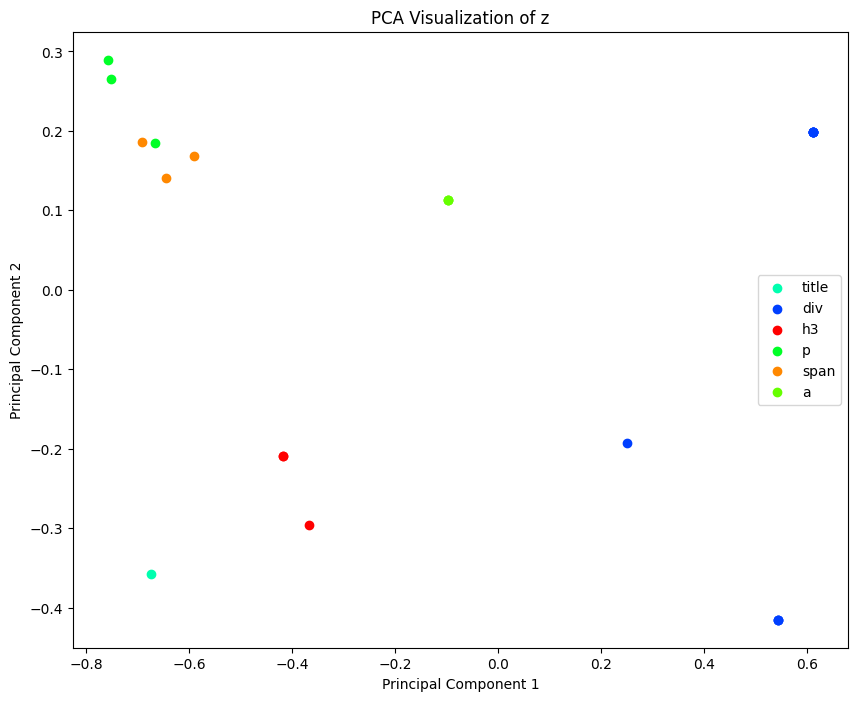

In [ ]:
# prompt: show a PCA 2d plot of z and make the color of the dots match the tags

transformed_z = pca.transform(z.detach().numpy())

# Create a color map for tags
color_map = {}
for i, tag in enumerate(set(tags)):
  if tag in ["a", "span", "p", "h3", "title", "div"]:
    color_map[tag] = plt.cm.get_cmap('hsv')(i / len(set(tags)))

# Plot the transformed data with colors based on tags
plt.figure(figsize=(10, 8))
for i, point in enumerate(transformed_z):
  if tags[i] in color_map:
    plt.scatter(point[0], point[1], c=[color_map[tags[i]]], label=tags[i])

# Add labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of z")

# Create a legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="best")

plt.show()


torch.Size([29, 32])


<ipython-input-20-0819bb1c2054>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z_tsne[i, 0], z_tsne[i, 1], c=color_map[tag], label=tag)


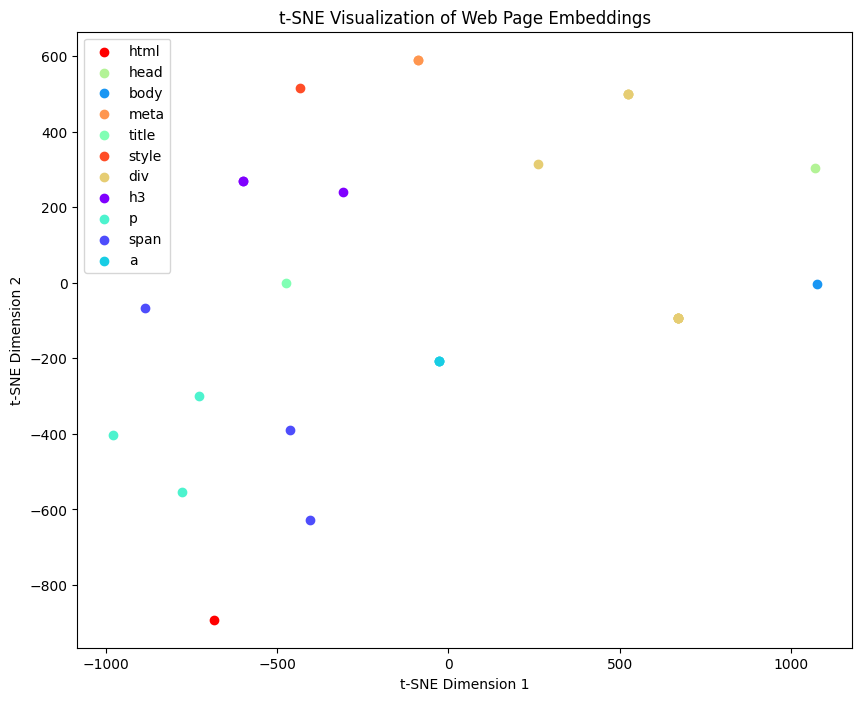

In [ ]:
# prompt: plot the t-SNE of z and make the color of the dots match the tags

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print(z.shape)
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=len(set(tags)))
z_tsne = tsne.fit_transform(z.detach().numpy())

# Create a color map for tags
unique_tags = set(tags)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_tags)))
color_map = {tag: color for tag, color in zip(unique_tags, colors)}

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for i, tag in enumerate(tags):
  plt.scatter(z_tsne[i, 0], z_tsne[i, 1], c=color_map[tag], label=tag)

# Add labels and legend
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Web Page Embeddings')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()


# Neighbour distances

In [ ]:
from lxml import etree
htmls = []
for i in range(-1, 9):

  # Create the root element
  root = etree.Element("div")

  # Track the current element to add children to
  current_element = root

  # Create 9 nested divs
  for j in range(9):
    new_div = etree.SubElement(current_element, "div")
    current_element = new_div
    if i == j:
      span = etree.SubElement(current_element, "h1")
      span.text = "Buy now"



  # Add a span at the 10th depth
  span = etree.SubElement(current_element, "button")
  span.text = ""

  # Convert the element tree to a string
  html_string = etree.tostring(root, pretty_print=True).decode()
  htmls.append(html_string)


In [ ]:
print(htmls[-1])

<div>
  <div>
    <div>
      <div>
        <div>
          <div>
            <div>
              <div>
                <div>
                  <div>
                    <h1>Buy now</h1>
                    <button></button>
                  </div>
                </div>
              </div>
            </div>
          </div>
        </div>
      </div>
    </div>
  </div>
</div>



In [ ]:
zs = []
for html in htmls:
  tags, x, e = web.extract(html)
  print(tags)
  print(x.shape)
  print(e.shape)
  edge_index = e.permute(1, 0)
  z = model.encode(x, edge_index=edge_index.to(torch.int64))[-1]
  zs.append(z)

['html', 'body', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'button']
torch.Size([13, 392])
torch.Size([12, 2])
['html', 'body', 'div', 'div', 'h1', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])
['html', 'body', 'div', 'div', 'div', 'h1', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])


<ipython-input-7-40c39adcf1c5>:14: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if root:


['html', 'body', 'div', 'div', 'div', 'div', 'h1', 'div', 'div', 'div', 'div', 'div', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])
['html', 'body', 'div', 'div', 'div', 'div', 'div', 'h1', 'div', 'div', 'div', 'div', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])
['html', 'body', 'div', 'div', 'div', 'div', 'div', 'div', 'h1', 'div', 'div', 'div', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])
['html', 'body', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'h1', 'div', 'div', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])
['html', 'body', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'h1', 'div', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])
['html', 'body', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'h1', 'div', 'button']
torch.Size([14, 392])
torch.Size([13, 2])
['html', 'body', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'h1', 'button']
torch.Size([14, 392])
torch

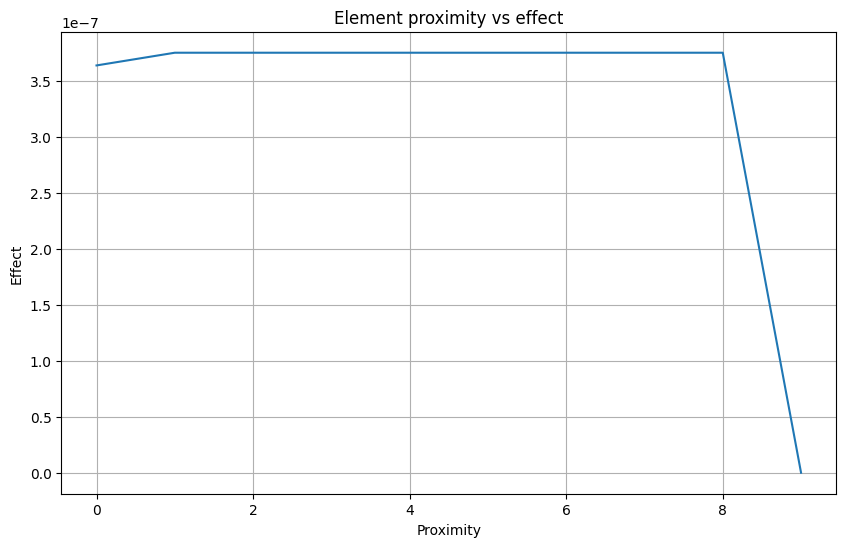

In [ ]:
e# prompt: find the distance between the vectors in zs and zs[0] and plot it

distances = [torch.dist(z, zs[0]).detach().numpy() for z in zs]

# Plot the distances
plt.figure(figsize=(10, 6))
plt.plot(list(reversed(distances)))
plt.xlabel("Proximity")
plt.ylabel("Effect")
plt.title("Element proximity vs effect")
plt.grid(True)
plt.show()

### Distance between the span and the p. (a sanity check)

In [ ]:

zs = []

tags, x, e = web.extract(htmls[-1])
print(tags)
edge_index = e.permute(1, 0)
z = model.encode(x, edge_index=edge_index.to(torch.int64))
print(torch.dist(z[-1], z[-2]))


['html', 'body', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'div', 'h1', 'button']
tensor(0.9063, grad_fn=<DistBackward0>)


<ipython-input-7-40c39adcf1c5>:14: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if root:



# Element features (tags)

In [ ]:
from lxml import etree
htmls = []
for tag in html_tags:

  # Create the root element
  root = etree.Element("div")

  # Track the current element to add children to
  current_element = root

  # Create 9 nested divs
  for j in range(9):
    new_div = etree.SubElement(current_element, "div")
    current_element = new_div

  # Add a span at the 10th depth
  ele = etree.SubElement(current_element, tag)

  # Convert the element tree to a string
  html_string = etree.tostring(root, pretty_print=True).decode()
  htmls.append(html_string)

In [ ]:
print(htmls[10])

<div>
  <div>
    <div>
      <div>
        <div>
          <div>
            <div>
              <div>
                <div>
                  <div>
                    <bdo/>
                  </div>
                </div>
              </div>
            </div>
          </div>
        </div>
      </div>
    </div>
  </div>
</div>



In [ ]:
zs = []
for html in htmls:
  tags, x, e = web.extract(html)
  edge_index = e.permute(1, 0)
  z = model.encode(x, edge_index=edge_index.to(torch.int64))[-1]
  zs.append(z)
distances = [torch.dist(z, zs[0]).detach().numpy() for z in zs]

<ipython-input-7-40c39adcf1c5>:14: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if root:


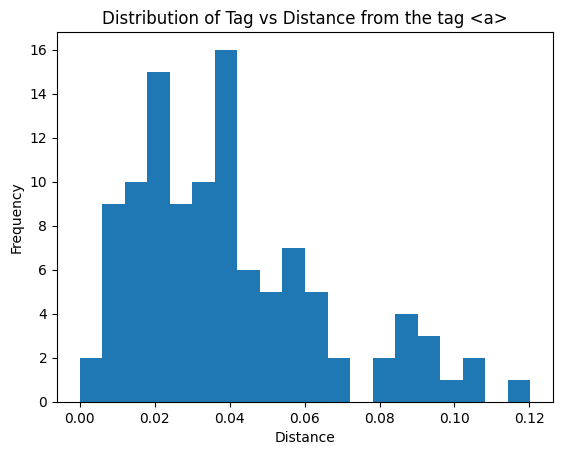

In [ ]:
# prompt: plot the distribution of distances

import matplotlib.pyplot as plt
plt.hist(distances, bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Tag vs Distance from the tag <a>')
plt.show()


# Element features (text)

In [ ]:
from lxml import etree
htmls = []
for text in ["", "buy now", "share with friends", "comment", "sort by", "234 views", "download here", "this is a description of the item that", "Is AI all hype?"]:

  # Create the root element
  root = etree.Element("div")

  # Track the current element to add children to
  current_element = root

  # Create 9 nested divs
  for j in range(9):
    new_div = etree.SubElement(current_element, "div")
    current_element = new_div

  # Add a span at the 10th depth
  ele = etree.SubElement(current_element, "span")
  ele.text = text

  # Convert the element tree to a string
  html_string = etree.tostring(root, pretty_print=True).decode()
  htmls.append(html_string)

print(htmls[5])

zs = []
for html in htmls:
  tags, x, e = web.extract(html)
  edge_index = e.permute(1, 0)
  z = model.encode(x, edge_index=edge_index.to(torch.int64))[-1]
  zs.append(z)
distances = [torch.dist(z, zs[0]).detach().numpy() for z in zs]

<div>
  <div>
    <div>
      <div>
        <div>
          <div>
            <div>
              <div>
                <div>
                  <div>
                    <span>234 views</span>
                  </div>
                </div>
              </div>
            </div>
          </div>
        </div>
      </div>
    </div>
  </div>
</div>



<ipython-input-7-40c39adcf1c5>:14: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if root:


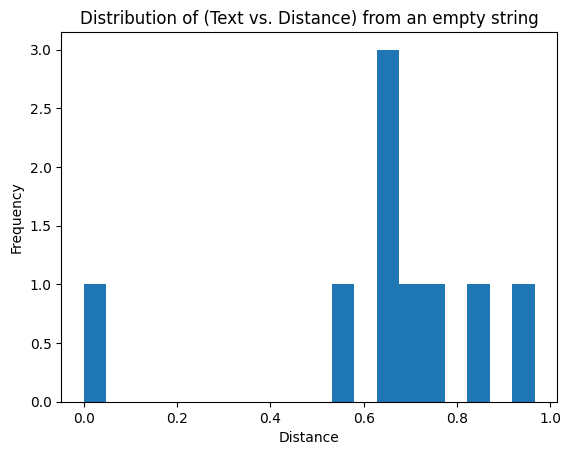

In [ ]:
import matplotlib.pyplot as plt
plt.hist(distances, bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of (Text vs. Distance) from an empty string')
plt.show()